In [2]:
import seaborn as sns
import pandas as pd
from googleapiclient.discovery import build
import warnings
warnings.filterwarnings('ignore')

In [3]:
apiKey = 'Your API KEY'
channelIDList = ["Your channel ID List"]
channelID = ','.join(channelIDList)
youtube = build('youtube','v3',developerKey=apiKey)
print(channelID)

UCqW8jxh4tH1Z1sWPbkGWL4g,UCRzYN32xtBf3Yxsx5BvJWJw,UCdp6GUwjKscp5ST4M4WgIpw,UC9TgvYNUsMBPl6J2xbL-4qg,UCnz-ZXXER4jOvuED5trXfEA,UCLLw7jmFsvfIVaUFsLs8mlQ,UCiT9RITQ9PW6BhXK0y2jaeg,UC7cs8q-gJRlGwj4A8OmCmXg,UC2UXDak6o7rBm23k3Vv5dww


### # function to get youtube channel statistics.

In [4]:

def getchannelStats(cID):
    dataframe = []
    request = request = youtube.channels().list(
        part='snippet,contentDetails,statistics',
        id=channelID,
    )
    response  = request.execute()
    try:
      for i in range(len(response['items'])):
          data = dict(
          ChannelName = response['items'][i]['snippet']['title'],
          Subscribers = response['items'][i]['statistics']['subscriberCount'],
          Views = response['items'][i]['statistics']['viewCount'],
          Videos = response['items'][i]['statistics']['videoCount'],
          PlaylistID = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'],
          # ChannelID = response['items'][i]['id'],
          Description = response['items'][i]['snippet']['description']
          )
          dataframe.append(data)
      return dataframe
    except Exception as e:
        return f'Some error occured due to {e}'

In [5]:
archivedata = getchannelStats(channelID)
archive = pd.DataFrame(archivedata)
archive

,ChannelName,Subscribers,Views,Videos,PlaylistID,Description
0,techTFQ,192000,9360776,87,UUnz-ZXXER4jOvuED5trXfEA,"Hi, I am Thoufiq! On this channel, I teach SQL..."
1,Akshat Shrivastava,1620000,157260071,626,UUqW8jxh4tH1Z1sWPbkGWL4g,Trying to put content that my 1-year old son- ...
2,Tina Huang,520000,22226679,121,UU2UXDak6o7rBm23k3Vv5dww,Hi! My name is Tina and I'm a ex-Meta data sci...
3,Ken Jee,241000,7963879,273,UUiT9RITQ9PW6BhXK0y2jaeg,"Hi, I'm Ken! Data Science, machine learning, A..."
4,Oggy Hindi - हिन्दी,10000000,5138020482,431,UU9TgvYNUsMBPl6J2xbL-4qg,Welcome to the official Oggy Youtube channel i...
5,TechWiser,1360000,204642214,826,UUdp6GUwjKscp5ST4M4WgIpw,"Founded in 2012, TechWiser helps people to sol..."
6,Alex The Analyst,453000,17813771,205,UU7cs8q-gJRlGwj4A8OmCmXg,My name is Alex Freberg and on this channel I ...
7,warikoo,2840000,223214715,886,UURzYN32xtBf3Yxsx5BvJWJw,"warikoo is a serial entrepreneur, a bestsellin..."
8,Luke Barousse,338000,15452999,134,UULLw7jmFsvfIVaUFsLs8mlQ,"What's up, Data Nerds! I'm Luke, a data analys..."


In [6]:
archive.dtypes

ChannelName    object
Subscribers    object
Views          object
Videos         object
PlaylistID     object
Description    object
dtype: object

In [7]:
archive['Subscribers'] = pd.to_numeric(archive['Subscribers'])
archive['Videos'] = pd.to_numeric(archive['Videos'])
archive['Views'] = pd.to_numeric(archive['Views'])
archive.dtypes

ChannelName    object
Subscribers     int64
Views           int64
Videos          int64
PlaylistID     object
Description    object
dtype: object

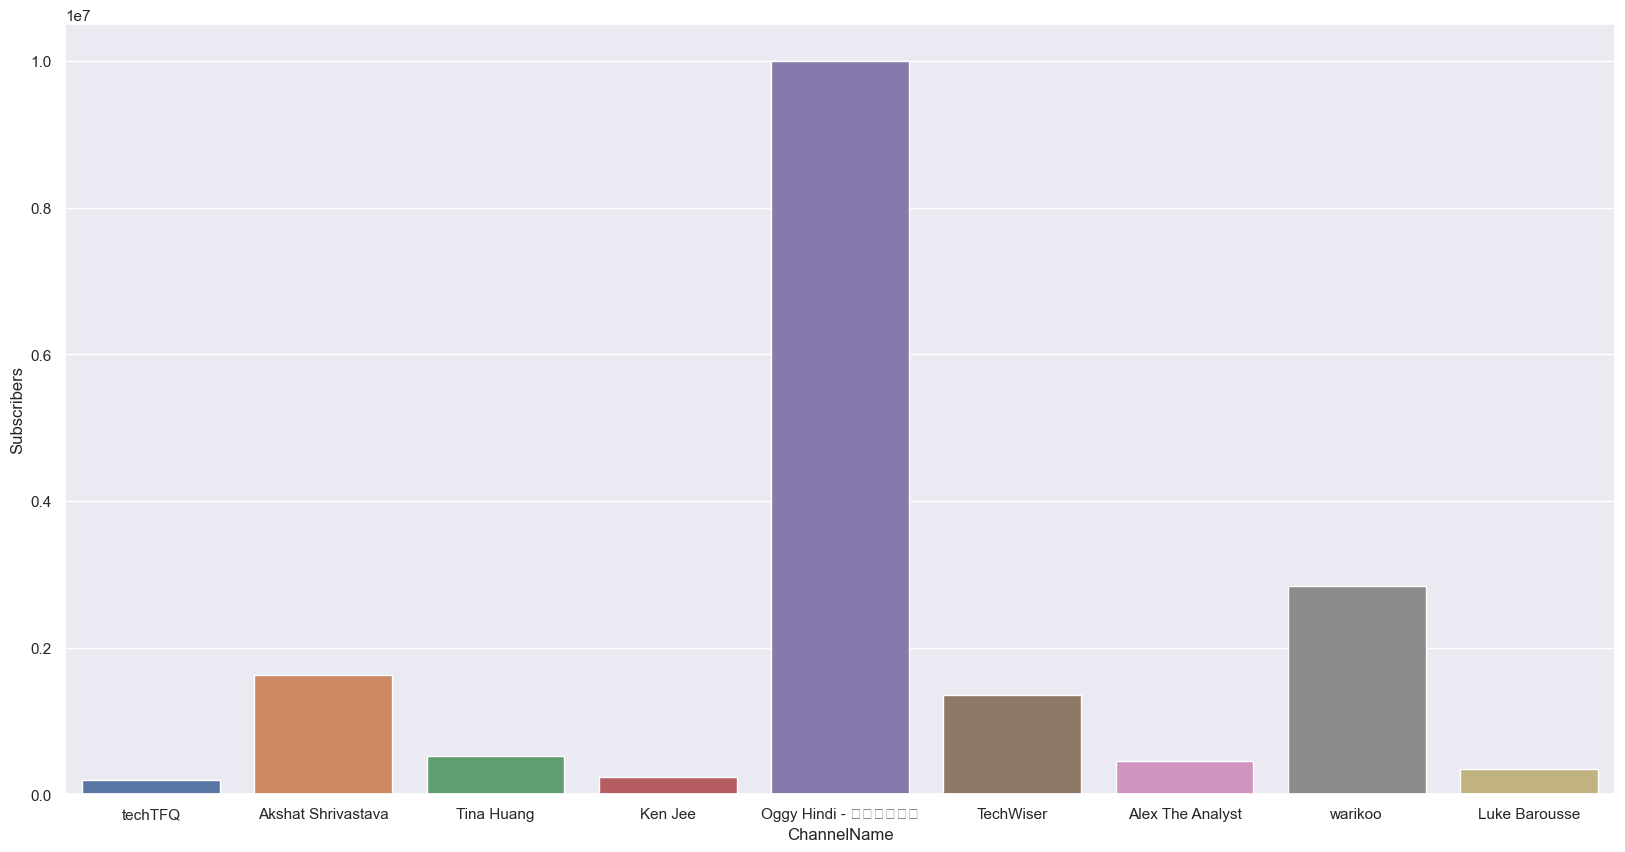

In [8]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.barplot(x='ChannelName', y ='Subscribers', data= archive)

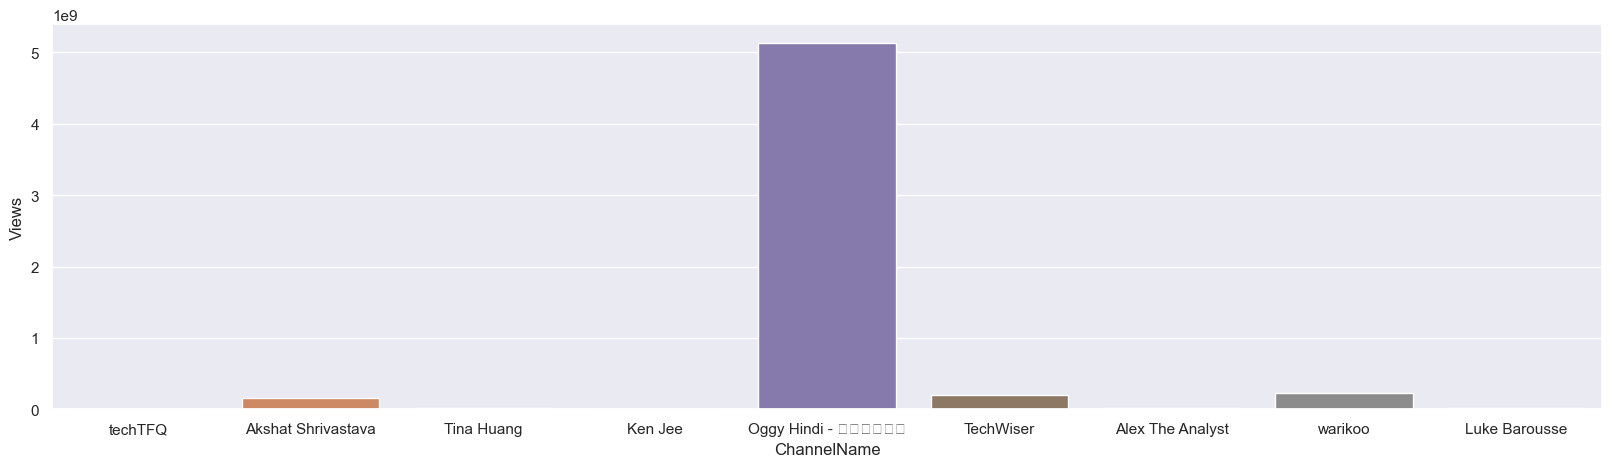

In [9]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.barplot(x='ChannelName', y ='Views', data= archive)

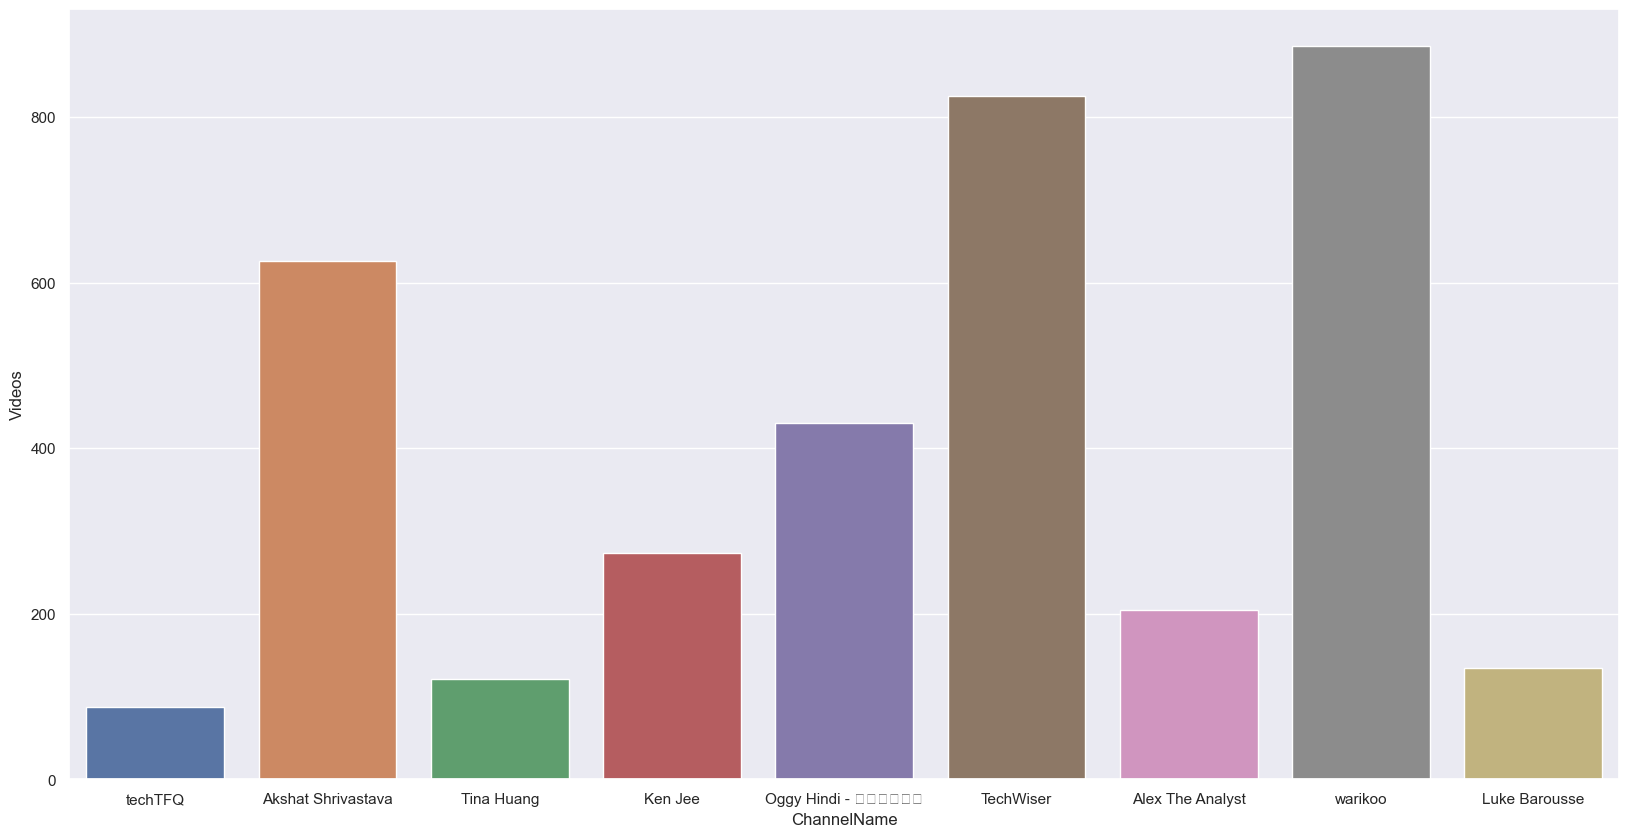

In [10]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.barplot(x='ChannelName', y ='Videos', data= archive)

In [11]:
archive

,ChannelName,Subscribers,Views,Videos,PlaylistID,Description
0,techTFQ,192000,9360776,87,UUnz-ZXXER4jOvuED5trXfEA,"Hi, I am Thoufiq! On this channel, I teach SQL..."
1,Akshat Shrivastava,1620000,157260071,626,UUqW8jxh4tH1Z1sWPbkGWL4g,Trying to put content that my 1-year old son- ...
2,Tina Huang,520000,22226679,121,UU2UXDak6o7rBm23k3Vv5dww,Hi! My name is Tina and I'm a ex-Meta data sci...
3,Ken Jee,241000,7963879,273,UUiT9RITQ9PW6BhXK0y2jaeg,"Hi, I'm Ken! Data Science, machine learning, A..."
4,Oggy Hindi - हिन्दी,10000000,5138020482,431,UU9TgvYNUsMBPl6J2xbL-4qg,Welcome to the official Oggy Youtube channel i...
5,TechWiser,1360000,204642214,826,UUdp6GUwjKscp5ST4M4WgIpw,"Founded in 2012, TechWiser helps people to sol..."
6,Alex The Analyst,453000,17813771,205,UU7cs8q-gJRlGwj4A8OmCmXg,My name is Alex Freberg and on this channel I ...
7,warikoo,2840000,223214715,886,UURzYN32xtBf3Yxsx5BvJWJw,"warikoo is a serial entrepreneur, a bestsellin..."
8,Luke Barousse,338000,15452999,134,UULLw7jmFsvfIVaUFsLs8mlQ,"What's up, Data Nerds! I'm Luke, a data analys..."


In [12]:
playlistid = archive.loc[archive['ChannelName']=='warikoo','PlaylistID'].iloc[0]
playlistid

'UURzYN32xtBf3Yxsx5BvJWJw'

### function to get a specific channel's video IDs.

In [13]:
def getvideoids(playlistid):
  request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlistid,
        maxResults = 50
    )
  response = request.execute()
  videoids = []
  for i in range(len(response['items'])):
        videoids.append(response['items'][i]['contentDetails']['videoId'])

  nextpagetoken = response.get('nextPageToken')
  morepages = True
  while morepages:
    if nextpagetoken is None:
      morepages = False
    else:
      request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlistid,
        maxResults = 50,
        pageToken=nextpagetoken
      )
      response = request.execute()
      for i in range(len(response['items'])):
        videoids.append(response['items'][i]['contentDetails']['videoId'])

      nextpagetoken = response.get('nextPageToken')

  return videoids
  

In [14]:
videIDs = getvideoids(playlistid)
len(videIDs)


887

### function to get a specific channel's video details based on video ID.

In [15]:
def getvideodetails(videIDs):
    videoStats = []
    for i in range(0,len(videIDs),50):
        request = youtube.videos().list(
            part = 'snippet,statistics',
            id = ','.join(videIDs[i:i+50])
        )
        response = request.execute()
        for video in response['items']:
            videoinfo = dict(
                Title = video['snippet']['title'],
                PublishedDate = video['snippet']['publishedAt'],
                ViewCount = video['statistics']['viewCount'],
                LikeCount = video['statistics']['likeCount'],
                # DislikeCount = video['statistics']['dislikeCount'],
                CommentCount = video['statistics']['commentCount']
            )
            videoStats.append(videoinfo)
    return videoStats

In [16]:
videodetails = getvideodetails(videIDs)
videodata = pd.DataFrame(videodetails)
videodata

,Title,PublishedDate,ViewCount,LikeCount,CommentCount
0,5 THINGS to do in AUSTRALIA! | Ankur Warikoo #...,2023-04-27T06:30:06Z,6873,805,12
1,7 Powerful LIFE LESSONS That'll BLOW Your Mind...,2023-04-25T12:30:12Z,64169,4450,208
2,3 SIGNS YOU ARE EMOTIONALLY INTELLIGENT! | Ank...,2023-04-25T06:30:11Z,46133,4107,52
3,Watch NOW or REGRET LATER! | 7 LESSONS People ...,2023-04-22T12:30:11Z,183847,11475,472
4,3 SIGNS a person TRUSTS YOU! | Ankur Warikoo #...,2023-04-22T06:30:00Z,38648,3633,47
...,...,...,...,...,...
882,Getting comfortable with being uncomfortable |...,2017-10-05T11:02:37Z,38196,2074,68
883,What is success? | Ankur Warikoo motivation | ...,2017-10-05T10:46:35Z,11313,477,21
884,Choosing the right company for job! | Ankur Wa...,2017-10-05T10:45:50Z,14377,514,14
885,Is the power of imagination causing you harm? ...,2017-09-07T05:10:12Z,24553,1039,36


In [17]:
videodata['PublishedDate'] = pd.to_datetime(videodata['PublishedDate']).dt.date
videodata['ViewCount'] = pd.to_numeric(videodata['ViewCount'])
videodata['LikeCount'] = pd.to_numeric(videodata['LikeCount'])
videodata['CommentCount'] = pd.to_numeric(videodata['CommentCount'])
videodata

,Title,PublishedDate,ViewCount,LikeCount,CommentCount
0,5 THINGS to do in AUSTRALIA! | Ankur Warikoo #...,2023-04-27,6873,805,12
1,7 Powerful LIFE LESSONS That'll BLOW Your Mind...,2023-04-25,64169,4450,208
2,3 SIGNS YOU ARE EMOTIONALLY INTELLIGENT! | Ank...,2023-04-25,46133,4107,52
3,Watch NOW or REGRET LATER! | 7 LESSONS People ...,2023-04-22,183847,11475,472
4,3 SIGNS a person TRUSTS YOU! | Ankur Warikoo #...,2023-04-22,38648,3633,47
...,...,...,...,...,...
882,Getting comfortable with being uncomfortable |...,2017-10-05,38196,2074,68
883,What is success? | Ankur Warikoo motivation | ...,2017-10-05,11313,477,21
884,Choosing the right company for job! | Ankur Wa...,2017-10-05,14377,514,14
885,Is the power of imagination causing you harm? ...,2017-09-07,24553,1039,36


In [18]:
top10videos = videodata.sort_values(by='ViewCount', ascending=False).head(10)
top10videos

,Title,PublishedDate,ViewCount,LikeCount,CommentCount
435,CREDIT CARDS se PAISE AISE KAMATE HAIN! | Anku...,2021-10-23,3999309,69433,4607
477,LOANS JALDI REPAY KARIYE! | Pay Off Debt Faste...,2021-07-17,3713582,109212,16054
158,The EASIEST WAY to make MONEY on YouTube! | An...,2022-10-29,3561697,250924,753
555,AAPKE 20s ke liye COMPLETE FINANCIAL PLANNING!...,2021-01-19,3278869,147274,12944
382,MY DAUGHTER AND COLOURS! | Ankur Warikoo #Shorts,2022-01-01,3030417,163013,697
156,3 BIGGEST JOB LIES the WORLD tells us EVERYDAY...,2022-11-01,2494603,161800,969
468,SIP KYA HAI? SIP vs LUMPSUM EXPLAINED! | Ankur...,2021-08-07,2447561,72821,3460
300,Rs. 500 to Rs. 3.5 CRORES! | Ankur Warikoo #Sh...,2022-02-27,2411182,159650,2967
429,30 ki AGE ke pehle RETIRE karna CHAHTE HAIN? Y...,2021-11-06,2354602,79815,5568
46,RAPID FIRE with @AbhiandNiyu | Ankur Warikoo #...,2023-03-04,2089489,143545,922


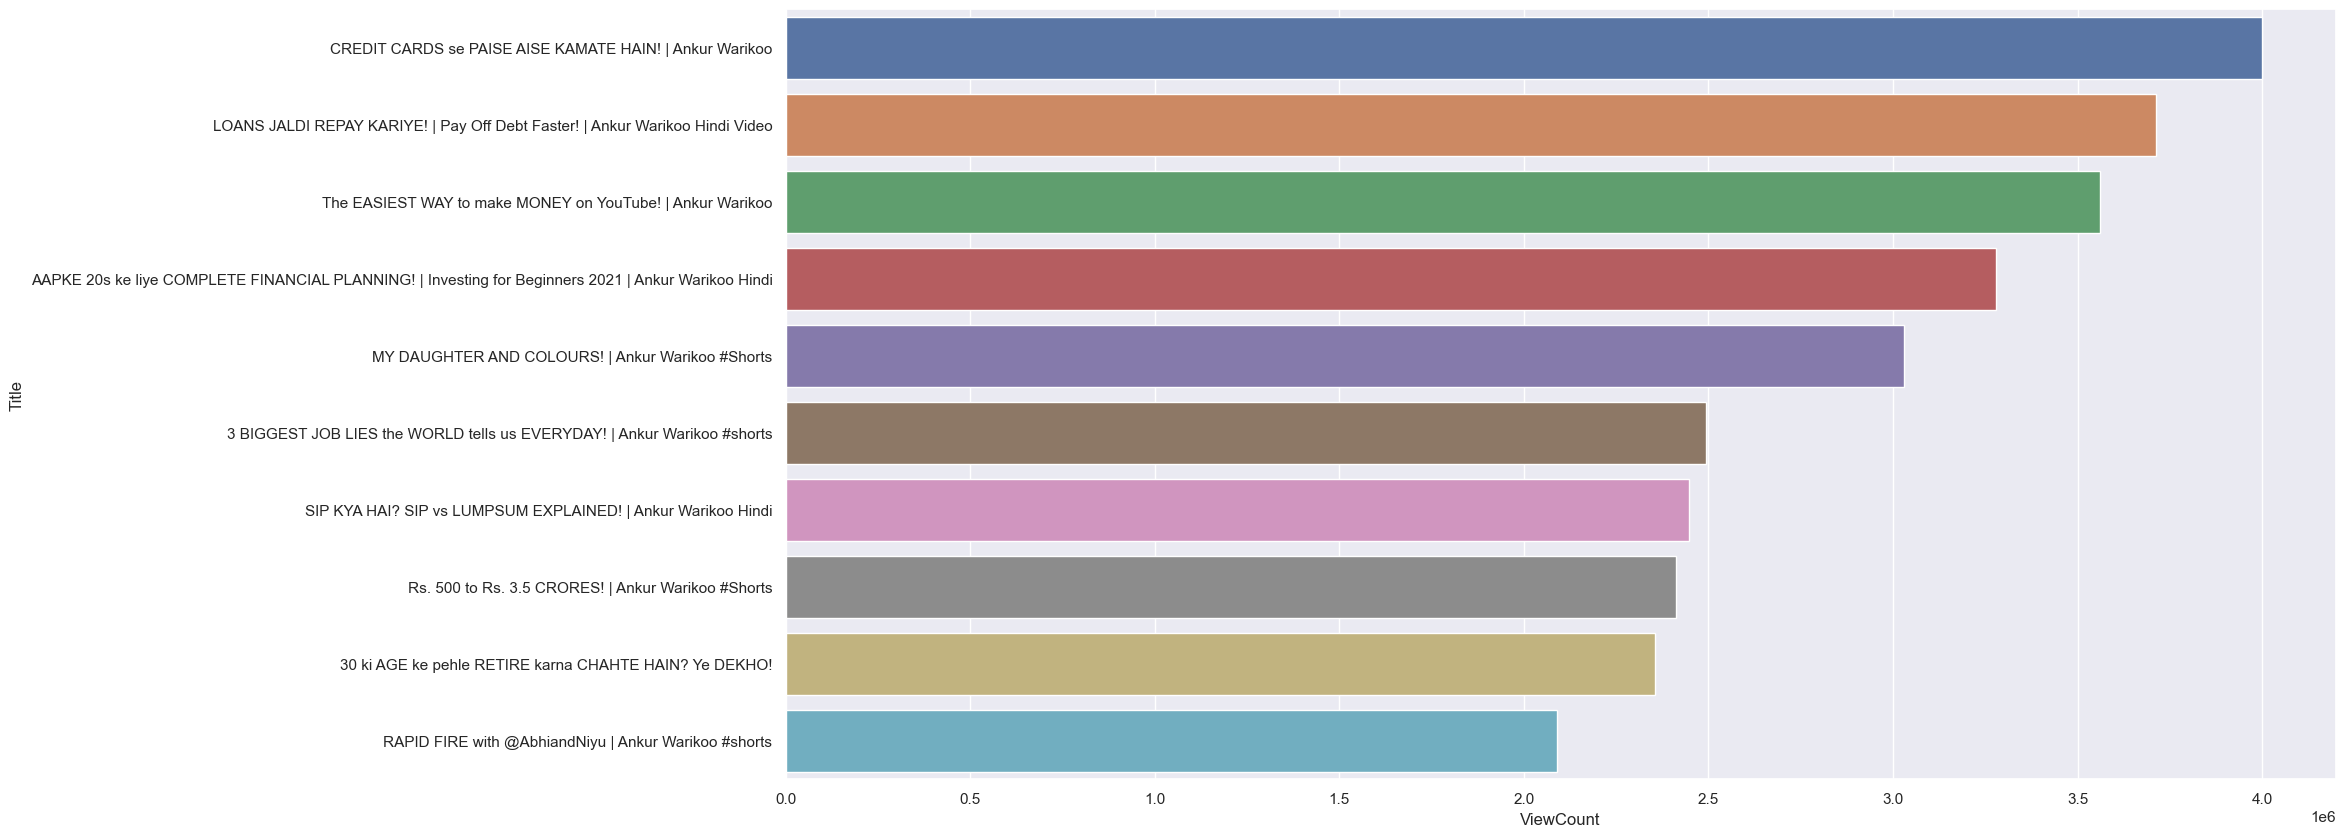

In [19]:
ax1 = sns.barplot(x='ViewCount',y='Title',data=top10videos)

In [20]:
videodata

,Title,PublishedDate,ViewCount,LikeCount,CommentCount
0,5 THINGS to do in AUSTRALIA! | Ankur Warikoo #...,2023-04-27,6873,805,12
1,7 Powerful LIFE LESSONS That'll BLOW Your Mind...,2023-04-25,64169,4450,208
2,3 SIGNS YOU ARE EMOTIONALLY INTELLIGENT! | Ank...,2023-04-25,46133,4107,52
3,Watch NOW or REGRET LATER! | 7 LESSONS People ...,2023-04-22,183847,11475,472
4,3 SIGNS a person TRUSTS YOU! | Ankur Warikoo #...,2023-04-22,38648,3633,47
...,...,...,...,...,...
882,Getting comfortable with being uncomfortable |...,2017-10-05,38196,2074,68
883,What is success? | Ankur Warikoo motivation | ...,2017-10-05,11313,477,21
884,Choosing the right company for job! | Ankur Wa...,2017-10-05,14377,514,14
885,Is the power of imagination causing you harm? ...,2017-09-07,24553,1039,36


In [21]:
videodata['Month'] = pd.to_datetime(videodata['PublishedDate']).dt.strftime("%b")

In [22]:
videodata

,Title,PublishedDate,ViewCount,LikeCount,CommentCount,Month
0,5 THINGS to do in AUSTRALIA! | Ankur Warikoo #...,2023-04-27,6873,805,12,Apr
1,7 Powerful LIFE LESSONS That'll BLOW Your Mind...,2023-04-25,64169,4450,208,Apr
2,3 SIGNS YOU ARE EMOTIONALLY INTELLIGENT! | Ank...,2023-04-25,46133,4107,52,Apr
3,Watch NOW or REGRET LATER! | 7 LESSONS People ...,2023-04-22,183847,11475,472,Apr
4,3 SIGNS a person TRUSTS YOU! | Ankur Warikoo #...,2023-04-22,38648,3633,47,Apr
...,...,...,...,...,...,...
882,Getting comfortable with being uncomfortable |...,2017-10-05,38196,2074,68,Oct
883,What is success? | Ankur Warikoo motivation | ...,2017-10-05,11313,477,21,Oct
884,Choosing the right company for job! | Ankur Wa...,2017-10-05,14377,514,14,Oct
885,Is the power of imagination causing you harm? ...,2017-09-07,24553,1039,36,Sep


In [23]:
vidoespermonth = videodata.groupby('Month',as_index=False).size()
vidoespermonth

,Month,size
0,Apr,80
1,Aug,67
2,Dec,97
3,Feb,82
4,Jan,98
5,Jul,37
6,Jun,50
7,Mar,92
8,May,51
9,Nov,77


In [24]:
sortorder = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [25]:
vidoespermonth.index = pd.CategoricalIndex(vidoespermonth['Month'],categories=sortorder, ordered=True)
vidoespermonth = vidoespermonth.sort_index()
vidoespermonth

,Month,size
Month,,
Jan,Jan,98
Feb,Feb,82
Mar,Mar,92
Apr,Apr,80
May,May,51
Jun,Jun,50
Jul,Jul,37
Aug,Aug,67
Sep,Sep,69


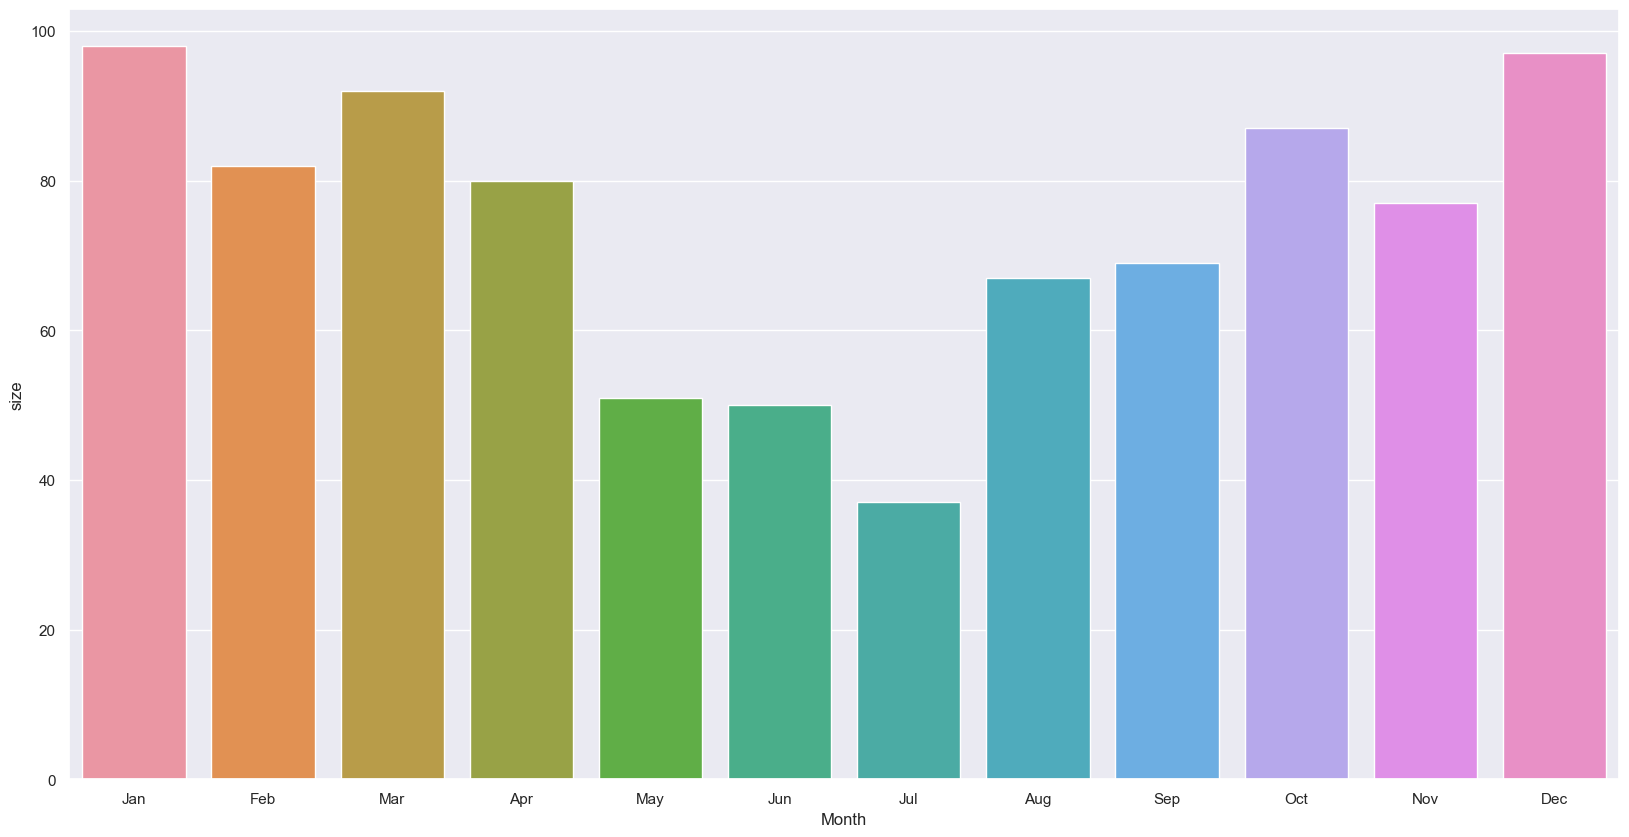

In [26]:
ax2 = sns.barplot(x='Month',y ='size',data=vidoespermonth)

In [27]:
videodata

,Title,PublishedDate,ViewCount,LikeCount,CommentCount,Month
0,5 THINGS to do in AUSTRALIA! | Ankur Warikoo #...,2023-04-27,6873,805,12,Apr
1,7 Powerful LIFE LESSONS That'll BLOW Your Mind...,2023-04-25,64169,4450,208,Apr
2,3 SIGNS YOU ARE EMOTIONALLY INTELLIGENT! | Ank...,2023-04-25,46133,4107,52,Apr
3,Watch NOW or REGRET LATER! | 7 LESSONS People ...,2023-04-22,183847,11475,472,Apr
4,3 SIGNS a person TRUSTS YOU! | Ankur Warikoo #...,2023-04-22,38648,3633,47,Apr
...,...,...,...,...,...,...
882,Getting comfortable with being uncomfortable |...,2017-10-05,38196,2074,68,Oct
883,What is success? | Ankur Warikoo motivation | ...,2017-10-05,11313,477,21,Oct
884,Choosing the right company for job! | Ankur Wa...,2017-10-05,14377,514,14,Oct
885,Is the power of imagination causing you harm? ...,2017-09-07,24553,1039,36,Sep


In [27]:
videodata.to_csv('./archive/VideoDetailsofKenJee.csv')